### Scene modeling photometry examples

This notebook will demonstrate a few use cases for the SMP software. We are only providing a very small subset of the full set of photometric measurements from DES (as there would be too many files otherwise).

The software assumes that the images have already been trimmed to (consistent) postage stamp sizes.  

In addition to the stamps, we will also need a table of zeropoints from DES and the PSF files for each image. These are provided in the `data` directory.

First, a few imports

In [1]:
#general
import numpy as np 
import matplotlib.pyplot as pl
import pickle

#smp
import smp, multismp

#### Simple case: high-$S/N$ source with no background
Let's start with a simple example of a $Y$ band exposure from the large TNO Eris. The information was taken from the photometry table provided in ()[].

In [2]:
# let's grab the information from the files and save them in a convenient table

import glob
import astropy.io.fits as pf 
import astropy.table as tb  
exp = []
ccd = []

for i in glob.glob('/Users/pedro/Documents/DES/multismp/stamps/01371046/*.fits'):
    a = pf.open(i)
    exp.append(a[0].header['EXPNUM'])
    ccd.append(a[0].header['CCDNUM'])
ccdt = tb.Table()
ccdt['EXPNUM'] = exp
ccdt['CCDNUM'] = ccd
ccdt['BAND'] = 'r'

In [3]:
sne = multismp.MultiDetection(ra=10.458238, dec=-43.375191, band = 'r', expnum = 563919, ccdnum = 12, name='01371046', color={i : 0.61 for i in ccdt['EXPNUM']}) 

In [4]:
sne.produceExposureList(ccdt, np.array(ccdt['EXPNUM']))

In [5]:
with open('/Users/pedro/Documents/DES/y6a1_zp.pkl', 'rb') as f:
	zp = pickle.load(f)


In [6]:
sne.constructImages(zp, '/Users/pedro/Documents/DES/multismp/stamps/01371046/hack/', 51)

In [43]:
ra_grid, dec_grid = smp.local_grid(sne.ra, sne.dec, 0.3 / 3600,40)


In [42]:
0.3 * 40, 0.35 * 30

(12.0, 10.5)

In [44]:
shift_x = {i : 0 for i in sne.exposures[sne.exposures['DETECTED']]['EXPNUM']}
shift_y = {i : 0 for i in sne.exposures[sne.exposures['DETECTED']]['EXPNUM']}
sne.constructPSFs(ra_grid, dec_grid,size=51, path='/Users/pedro/Documents/DES/multismp/psfs/',shift_x = shift_x, shift_y = shift_y, )

PSF matrix


In [45]:
sne.constructDesignMatrix(51)

Background
Design


In [46]:
sne.solvePhotometry(False, False,)

Product
Solving
Solved


/home/pedro/Dropbox/DES/SceneModelingPhotometry/multismp.py:194: RuntimeWarning: invalid value encountered in log10
  self.mag = -2.5 * np.log10(self.flux) + 30


In [47]:
sne.pred = sne.design @ sne.X
sne.res = sne.pred - sne.image

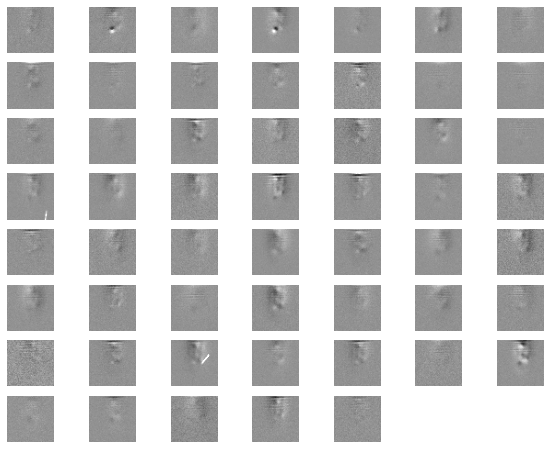

In [48]:
from image_tools import clippedMean
for i in range(54):
    pl.subplot(8, 7, i+1)
    this = sne.res[i*51*51 : (i+1) * 51 * 51]
    im = sne.image[i*51*51 : (i+1) * 51 * 51]
    sig = np.sqrt(clippedMean(im, 4)[1])
    pl.imshow(this.reshape((51,51)), cmap='gray_r', vmin=-3*sig, vmax=4*sig)
    pl.axis('off')

In [13]:
exp = tb.Table.read('/Users/pedro/Dropbox/DES/DESTNOSIM/data/y6a1snc.exposures.positions.fits')
exp

BAND,cov,covwarn,dec,ecl_lat,ecl_lon,mjd_mid,observatory,obs_ecl_lon,ra,filter,FIELD,m50,k,c,expnum
bytes5,float64[3],bool,float64,float64,float64,float64,float64[3],float64,float64,bytes1,bytes5,float64,float64,float64,int32
g,0.0 .. 0.0,False,-43.998000000000005,-43.199551315258915,-13.273900077217045,56255.079153815735,0.4617832432118883 .. 0.34574318997106906,62.02488079566447,9.5,g,SN-E2,23.1881134064656,4.0,1.0,154864
g,0.0 .. 0.0,False,-43.009611,-41.73486489836646,-13.91180820683103,56264.044498315736,0.3180171587736905 .. 0.36989252377752413,71.12361387570985,7.8745829999999994,g,SN-E1,24.560096292378535,4.0,1.0,157445
g,0.0 .. 0.0,False,-43.998000000000005,-43.199551315258915,-13.273900077217045,56264.06098698573,0.3177430216632768 .. 0.369928668906436,71.14050925793107,9.5,g,SN-E2,24.638606488547136,4.0,1.0,157452
g,0.0 .. 0.0,False,-4.9295,-17.648183287166912,30.47175096284056,56264.08018991573,0.3174232642374069 .. 0.36997072546486737,71.16020774689007,34.475833,g,SN-X1,24.444421822090703,4.0,1.0,157460
g,0.0 .. 0.0,False,-6.4121109999999994,-19.44684533207825,31.106586626308204,56264.095388775735,0.31716982231240787 .. 0.37000398322549305,71.1758139118092,35.664583,g,SN-X2,24.449278182549257,4.0,1.0,157467
g,0.0 .. 0.0,False,0.0,-15.686164432116938,40.37095086487607,56264.112979225734,0.31687613027310935 .. 0.3700424416934053,71.1938903607917,42.82,g,SN-S1,24.15131981607138,4.0,1.0,157474
g,0.0 .. 0.0,False,-0.988389,-16.127191890168895,38.44682320523521,56264.13126415573,0.3165704546036321 .. 0.3700823814995259,71.21269462458518,41.194583,g,SN-S2,23.755555143550147,4.0,1.0,157482
g,0.0 .. 0.0,False,-29.088389,-46.73862387803006,41.87968179579182,56264.17459476573,0.31584473990268785 .. 0.3701768776114524,71.25729665578565,54.274167,g,SN-C2,23.70083148782691,4.0,1.0,157500
g,0.0 .. 0.0,False,-4.6000000000000005,-18.007863693468085,32.53278416499474,56266.15463864169,0.282876122147116 .. 0.37426453694718875,73.27048466392455,36.45,g,SN-X3,24.425168492535988,4.0,1.0,158144


In [14]:
exp['EXPNUM'] = exp['expnum']
snexp = tb.join(sne.exposures, exp['EXPNUM', 'mjd_mid'])
snexp

EXPNUM,CCDNUM,BAND,DETECTED,mjd_mid
int64,int64,str1,bool,float64
563919,12,r,True,57614.210920449776
566555,12,r,True,57623.224766229774
568216,12,r,True,57627.36654178978
568713,12,r,True,57629.23069553978
570170,12,r,True,57633.22818264978
571436,12,r,True,57637.220347369774
572953,12,r,True,57641.09291793978
575727,12,r,True,57653.07095082977
577405,12,r,True,57657.211564729776


In [17]:
pl.style.use('/Users/pedro/Dropbox/DES/des.mplstyle')

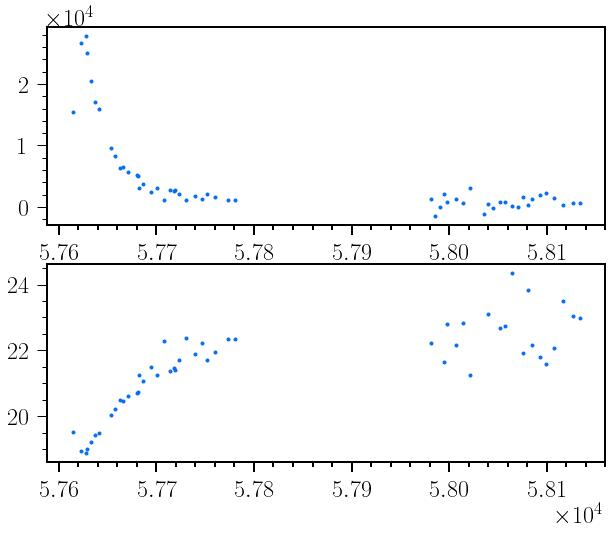

In [16]:
pl.subplot(2,1,1)
pl.plot(snexp['mjd_mid'],sne.flux, '.')
pl.subplot(2,1,2)
pl.plot(snexp['mjd_mid'],sne.mag, '.')
pl.show()
